# CIFAR-10 Image Classification (CNN)



### **1. Dataset**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Set GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)


def load_data_cifar10(batch_size, resize=None):
    trans = [torchvision.transforms.ToTensor()]
    if resize:
        trans.insert(0, torchvision.transforms.Resize(resize))
    trans = torchvision.transforms.Compose(trans)

    #Training Data
    cifar10_train = torchvision.datasets.CIFAR10(
        root='./data', train=True, transform=trans, download=True)

    #Testing Data
    cifar10_test = torchvision.datasets.CIFAR10(
        root='./data', train=False, transform=trans, download=True)

    return (DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2),
            DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2))

batch_size = 128
train_iter, test_iter = load_data_cifar10(batch_size)

X, y = next(iter(train_iter))
print(X.size())
print(y.size())

cuda


100%|██████████| 170M/170M [00:01<00:00, 107MB/s]


torch.Size([128, 3, 32, 32])
torch.Size([128])


### **2. Basic Architecture**

#### 2.1 Intermediate Block

In [3]:
import torch

class IntermediateBlock(torch.nn.Module):
    def __init__(self, num_Lconv_layers, input_channels, output_channels, kernel_size, stride, padding):

        super(IntermediateBlock, self).__init__()
        self.num_Lconv_layers = num_Lconv_layers #Store L

        # Create L independent convolutional layers.
        self.convs = torch.nn.ModuleList()
        for i in range(num_Lconv_layers):
            L_conv_layers = torch.nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding)
            self.convs.append(L_conv_layers)

        # Fully connected layer to compute coefficients a from the channel-wise average m.
        # m has dimension input_channels; we want an output vector of size num_Lconv_layers.
        self.fc = torch.nn.Linear(input_channels, num_Lconv_layers)

    def forward(self, x):
        # Vector m for each image; shape = [batch, c]
        m = torch.mean(x,dim=(2, 3))

        # Vector a from m; shape = [batch, L]
        a = self.fc(m)
        a = torch.nn.functional.softmax(a, dim=1) #Normalisation, so weights sum to 1

        out = 0
        for i, conv_layer in enumerate(self.convs):
            conv_output = conv_layer(x)  # Shape: [batch_size, output_channels, h, w]
            out += a[:, i].reshape(-1, 1, 1, 1) * conv_output

        return out


#### 2.2 Output Block

In [8]:
class OutputBlock(torch.nn.Module):
    def __init__(self, input_channels, output_classes, hidden_sizes= None):
        super(OutputBlock, self).__init__()
        layers = []

        if hidden_sizes is not None:
            input_dim = input_channels

            for hidden in hidden_sizes:
                layers.append(torch.nn.Linear(input_dim, hidden))
                layers.append(torch.nn.ReLU())
                input_dim = hidden
            layers.append(torch.nn.Linear(input_dim, output_classes))
        else:
            layers.append(torch.nn.Linear(input_channels, output_classes))

        #Compile all layers
        self.fc_seq = torch.nn.Sequential(*layers)

    def forward(self, x):
        m = torch.mean(x,dim=(2, 3))  # m now has shape [batch, channels]
        out = self.fc_seq(m)    # out has shape [batch, output_classes]
        return out

#### 2.3 Model- CIFAR10Net

In [9]:
class CIFAR10Net(torch.nn.Module):
    def __init__(self):
        super(CIFAR10Net, self).__init__()
        self.block1 = torch.nn.Sequential(
                        IntermediateBlock(num_Lconv_layers=3,input_channels=3, output_channels=32,
                                        kernel_size=3, stride=1, padding=1),
                        torch.nn.BatchNorm2d(32),
                        torch.nn.ReLU(),
                        torch.nn.MaxPool2d(2,2))

        self.block2 = torch.nn.Sequential(
                        IntermediateBlock(num_Lconv_layers=3,input_channels=32, output_channels=64,
                                          kernel_size=3, stride=1, padding=1),
                        torch.nn.BatchNorm2d(64),
                        torch.nn.ReLU(),
                        torch.nn.MaxPool2d(2,2))

        self.block3 = torch.nn.Sequential(
                        IntermediateBlock(num_Lconv_layers=3,input_channels=64, output_channels=64,
                                          kernel_size=3, stride=1, padding=1),
                        torch.nn.BatchNorm2d(64),
                        torch.nn.ReLU(),
                        torch.nn.MaxPool2d(2,2))

        # Output block
        self.out_block = OutputBlock(input_channels=64, output_classes=10, hidden_sizes=None)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.out_block(x)
        return x

In [10]:
model = CIFAR10Net()

# Xavier initialization
def init_weights(m):
    if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.BatchNorm2d):
        torch.nn.init.constant_(m.weight, 1)
        torch.nn.init.constant_(m.bias, 0)

model.apply(init_weights)

print(model)

CIFAR10Net(
  (block1): Sequential(
    (0): IntermediateBlock(
      (convs): ModuleList(
        (0-2): 3 x Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (fc): Linear(in_features=3, out_features=3, bias=True)
    )
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): IntermediateBlock(
      (convs): ModuleList(
        (0-2): 3 x Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (fc): Linear(in_features=32, out_features=3, bias=True)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): IntermediateBlock(
      (convs): ModuleList(
        (0-2): 3 x Conv2d(64, 64, kernel_size

### **3. Training and Testing**

In [11]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1)
    return (y_hat == y).float().sum()

def evaluate_metric(model, data_iter, metric):
    c = torch.tensor(0., device=device)
    n = torch.tensor(0., device=device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        c += metric(logits, y)
        n += torch.tensor(len(y), device=device)
    return c / n


In [ ]:
import time
import matplotlib.pyplot as plt

#Move CNN to GPU
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = []
train_accs = []
test_accs = []
num_epochs = 20
best_acc = 0.0


for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train()

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X)

        l = loss(logits, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        losses.append(float(l))

    with torch.no_grad():
        model.eval()
        train_acc = evaluate_metric(model, train_iter, correct)
        test_acc = evaluate_metric(model, test_iter, correct)

        # Move the accuracy values from GPU to CPU for plotting the graph in later stage.
        train_accs.append(train_acc.cpu().item() if torch.is_tensor(train_acc) else train_acc)
        test_accs.append(test_acc.cpu().item() if torch.is_tensor(test_acc) else test_acc)

        end_time = time.perf_counter()
        print(f'Training accuracy: {train_acc:.4f}. Testing accuracy: {test_acc:.4f}. Duration: {end_time - start_time:.3f}s.')

        if test_acc > best_acc:
            best_acc = test_acc
            print(f'Saving best model with Test Acc: {test_acc:.2f}')
            torch.save(model.state_dict(), 'best_model.pth') # Checkpoints

print(f'Best test accuracy: {best_acc:.2f}')



Epoch 1/20.
Training accuracy: 0.3343. Testing accuracy: 0.3291. Duration: 11.628s.
Saving best model with Test Acc: 0.33

Epoch 2/20.
Training accuracy: 0.5409. Testing accuracy: 0.5296. Duration: 9.806s.
Saving best model with Test Acc: 0.53

Epoch 3/20.
Training accuracy: 0.4634. Testing accuracy: 0.4573. Duration: 9.724s.

Epoch 4/20.
Training accuracy: 0.4855. Testing accuracy: 0.4642. Duration: 10.112s.

Epoch 5/20.
Training accuracy: 0.6061. Testing accuracy: 0.5826. Duration: 9.649s.
Saving best model with Test Acc: 0.58

Epoch 6/20.
Training accuracy: 0.7336. Testing accuracy: 0.6925. Duration: 9.846s.
Saving best model with Test Acc: 0.69

Epoch 7/20.
Training accuracy: 0.7700. Testing accuracy: 0.7225. Duration: 9.628s.
Saving best model with Test Acc: 0.72

Epoch 8/20.
Training accuracy: 0.7485. Testing accuracy: 0.6957. Duration: 9.509s.

Epoch 9/20.
Training accuracy: 0.7393. Testing accuracy: 0.6827. Duration: 9.632s.

Epoch 10/20.
Training accuracy: 0.7839. Testing acc

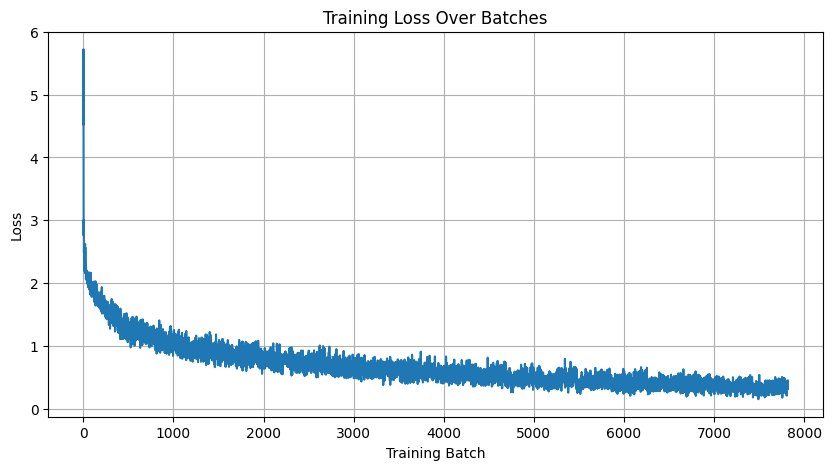

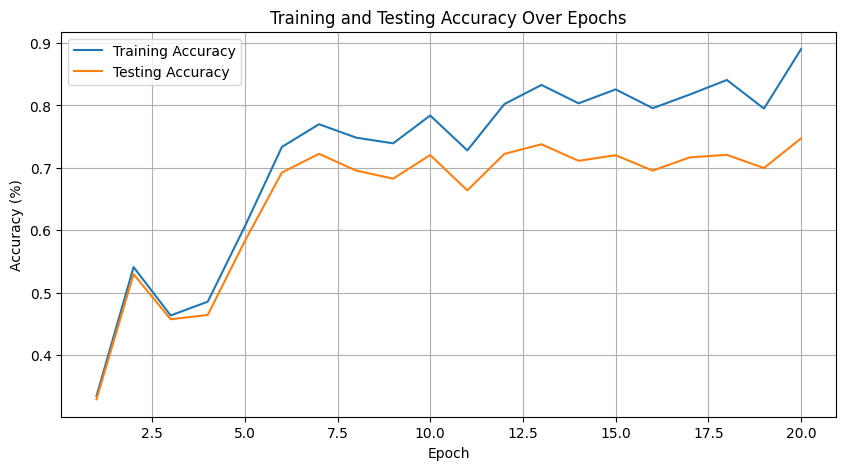

In [13]:
import matplotlib.pyplot as plt

# Training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Training Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over Batches')
plt.grid(True)
plt.show()

# Training and testing accuracy
plt.figure(figsize=(10, 5))
epochs_range = range(1, num_epochs + 1)
plt.plot(epochs_range, train_accs, label='Training Accuracy')
plt.plot(epochs_range, test_accs, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### **4. Improving the results**

#### 4.1.1 Data Loader

- Data Augmentation is applied to the CIFAR10 dataset.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Set GPU (remove the # when rerunning the code)
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(device)

def load_data_cifar10(batch_size):
    # Data augmentation.
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))])

    cifar10_train = torchvision.datasets.CIFAR10(
        root='./data', train=True, transform=transform_train, download=True)

    cifar10_test = torchvision.datasets.CIFAR10(
        root='./data', train=False, transform=transform_test, download=True)

    return (DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2),
            DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2))

batch_size = 64
train_iter, test_iter = load_data_cifar10(batch_size)

X, y = next(iter(train_iter))
print(X.size())
print(y.size())

torch.Size([64, 3, 32, 32])
torch.Size([64])


### **4.2. Improved Architecture**

- The basic architecture of the `IntermediateBlock` and the `OutputBlock` is the same as mentioned in section 2.1 and section 2.2 respectively.

- The following shows that the overall arcitecture of the improved neural network trained on the CIFAR10 dataset with increase of the number of convolutional layers and changes in the hyperparameters (details described in the pdf document).

#### 4.2.1 Improved Model- Improved_CIFAR10Net

In [ ]:
import torch
class Improved_CIFAR10Net(torch.nn.Module):
    def __init__(self):
        super(Improved_CIFAR10Net, self).__init__()

        self.block1 = torch.nn.Sequential(
            IntermediateBlock(num_Lconv_layers=3, input_channels=3, output_channels=64,
                            kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2))

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU())

        self.block2 = torch.nn.Sequential(
            IntermediateBlock(num_Lconv_layers=6, input_channels=64, output_channels=128,
                            kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Dropout(0.2))

        self.block3 = torch.nn.Sequential(
            IntermediateBlock(num_Lconv_layers=8, input_channels=128, output_channels=256,
                            kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Dropout(0.4))

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU())

        self.block4 = torch.nn.Sequential(
            IntermediateBlock(num_Lconv_layers=6, input_channels=256, output_channels=512,
                            kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4))

        self.block5 = torch.nn.Sequential(
            IntermediateBlock(num_Lconv_layers=3, input_channels=512, output_channels=512,
                            kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Dropout(0.5))

        self.out_block = OutputBlock(input_channels=512, output_classes=10, hidden_sizes=[256, 128])

    def forward(self, x):
        x = self.block1(x)
        x = self.conv1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.conv2(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.out_block(x)
        return x

In [ ]:
improved_model = Improved_CIFAR10Net()

# Xavier initialization
def init_weights(m):
    if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.BatchNorm2d):
        torch.nn.init.constant_(m.weight, 1)
        torch.nn.init.constant_(m.bias, 0)

improved_model.apply(init_weights)
print(improved_model)

Improved_CIFAR10Net(
  (block1): Sequential(
    (0): IntermediateBlock(
      (convs): ModuleList(
        (0-2): 3 x Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (fc): Linear(in_features=3, out_features=3, bias=True)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): IntermediateBlock(
      (convs): ModuleList(
        (0-5): 6 x Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (fc): Linear(in_features=64, out_features=6, bias=True)
    )
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, strid

### **4.3. Improved Training and Testing**

In [ ]:
# Set GPU (remove the # when rerunning the code)
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(device)

def correct(logits, y):
    y_hat = logits.argmax(axis=1)
    return (y_hat == y).float().sum()

def evaluate_metric(improved_model, data_iter, metric):
    c = torch.tensor(0., device=device)
    n = torch.tensor(0., device=device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        logits = improved_model(X)
        c += metric(logits, y)
        n += torch.tensor(len(y), device=device)
    return c / n

In [ ]:
import time

# Move model to GPU
improved_model = improved_model.to(device)

loss = torch.nn.CrossEntropyLoss()
lr = 0.01
improved_optimizer = torch.optim.Adam(improved_model.parameters(), lr=lr)
improved_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(improved_optimizer, T_max=200)


improved_losses = []
improved_train_accs = []
improved_test_accs = []

improved_best_acc = 0.0

num_epochs = 100
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    improved_model.train()

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)  # Move data to device
        logits = improved_model(X)

        improved_l = loss(logits, y)
        improved_optimizer.zero_grad()
        improved_l.backward()
        improved_optimizer.step()

        improved_losses.append(float(improved_l))

    improved_scheduler.step()

    with torch.no_grad():
        improved_model.eval()
        improved_train_acc = evaluate_metric(improved_model, train_iter, correct)
        improved_test_acc = evaluate_metric(improved_model, test_iter, correct)

        # Move the accuracy values from GPU to CPU for plotting the graph in later stage.
        improved_train_accs.append(improved_train_acc.cpu().item() if torch.is_tensor(improved_train_acc) else improved_train_acc)
        improved_test_accs.append(improved_test_acc.cpu().item() if torch.is_tensor(improved_test_acc) else improved_test_acc)

        end_time = time.perf_counter()
        print(f'Improved Training accuracy: {improved_train_acc:.4f}. Improved Testing accuracy: {improved_test_acc:.4f}. Duration: {end_time - start_time:.3f}s.')

    if improved_test_acc > improved_best_acc:
        improved_best_acc = improved_test_acc
        print(f'Saving best model with Improved Test Acc: {improved_test_acc:.2f}%')
        torch.save(improved_model.state_dict(), 'improved_best_model.pth') # Checkpoints

print(f'Improved_Best test accuracy: {improved_best_acc:.2f}%')



Epoch 1/100.
Improved Training accuracy: 0.2393. Improved Testing accuracy: 0.2447. Duration: 28.148s.
Saving best model with Improved Test Acc: 0.24%

Epoch 2/100.
Improved Training accuracy: 0.2635. Improved Testing accuracy: 0.2587. Duration: 27.973s.
Saving best model with Improved Test Acc: 0.26%

Epoch 3/100.
Improved Training accuracy: 0.2769. Improved Testing accuracy: 0.2583. Duration: 27.801s.

Epoch 4/100.
Improved Training accuracy: 0.4176. Improved Testing accuracy: 0.4168. Duration: 27.884s.
Saving best model with Improved Test Acc: 0.42%

Epoch 5/100.
Improved Training accuracy: 0.5294. Improved Testing accuracy: 0.5195. Duration: 27.823s.
Saving best model with Improved Test Acc: 0.52%

Epoch 6/100.
Improved Training accuracy: 0.6296. Improved Testing accuracy: 0.6161. Duration: 28.822s.
Saving best model with Improved Test Acc: 0.62%

Epoch 7/100.
Improved Training accuracy: 0.6968. Improved Testing accuracy: 0.6847. Duration: 28.017s.
Saving best model with Improved 

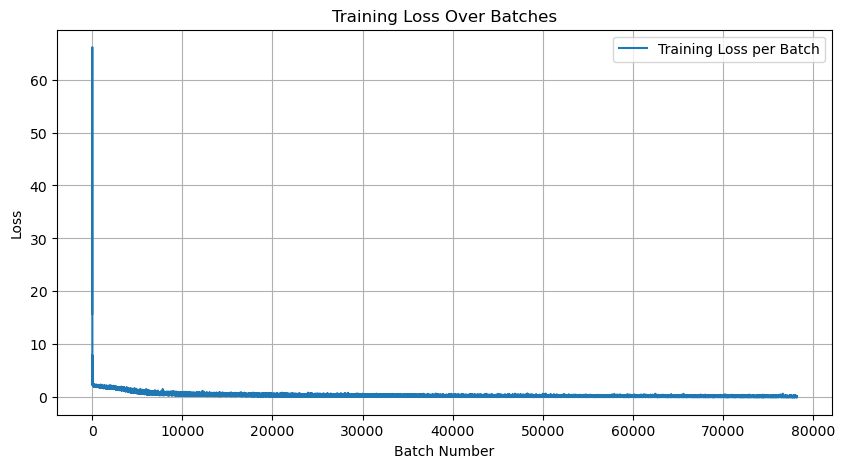

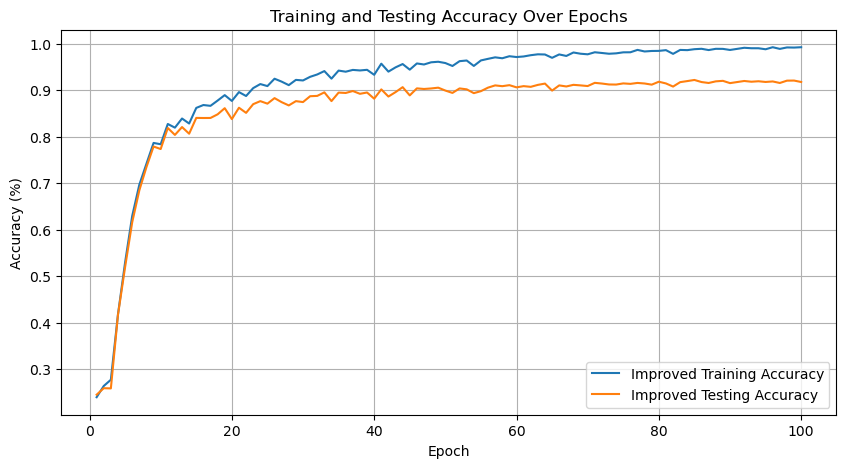

In [ ]:
import matplotlib.pyplot as plt

# Training loss
plt.figure(figsize=(10, 5))
plt.plot(improved_losses, label='Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss Over Batches')
plt.legend()
plt.grid(True)
plt.show()

# Training and testing accuracy
plt.figure(figsize=(10, 5))
epochs_range = range(1, num_epochs + 1)
plt.plot(epochs_range, improved_train_accs, label='Improved Training Accuracy')
plt.plot(epochs_range, improved_test_accs, label='Improved Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()